In [248]:
# Imports
import geopandas as gpd
import numpy as np
import pandas as pd
import os 
import requests
import json
import datetime
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import geopandas as gpd
from shapely.geometry import Point

### Purple Air

In [249]:
df_purple = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016_present.csv")
df_purple = df_purple.sort_values(['date'], ascending = False)

In [250]:
df_purple = df_purple[['sensor_id','latitude','longitude','date','altitude','pm2.5_atm','pm10.0_atm']]
df_purple.rename(columns = {'pm2.5_atm':'pm2','pm10.0_atm':'pm10'},inplace=True)
def parse_date(date_str):
    for fmt in ('%m/%d/%Y', '%m/%d/%y'):  #formats to try
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT

df_purple['date'] = df_purple['date'].apply(parse_date)
df_purple['date'] = pd.to_datetime(df_purple['date'], format='%m/%d/%y')
df_purple['month'] = df_purple['date'].dt.month
df_purple.head()


sensor_id   latitude   longitude       date  altitude     pm2    pm10  \
268877     165997  40.733875 -111.841090 2023-09-09      4561  2.2205  2.4150   
269301     169779  40.769947 -111.847015 2023-09-09      4758  2.2595  2.8850   
231900      91975  40.710438 -111.847490 2023-09-09      4455  3.0910  4.2670   
66556        6622  40.743610 -111.876320 2023-09-09      4256  2.6005  2.7985   
167519      33077  41.137455 -112.029526 2023-09-09      4523  1.8840  2.0530   

        month  
268877      9  
269301      9  
231900      9  
66556       9  
167519      9

In [251]:
# Convert df_purple to a GeoDataFrame
gdf_purple = gpd.GeoDataFrame(
    df_purple, 
    geometry=gpd.points_from_xy(df_purple.longitude, df_purple.latitude),
    crs="EPSG:4326" # Assuming the coordinates are in WGS84
)

In [252]:
#gdf_image_labels

In [253]:
# Load Dataset for Join
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')

In [254]:
geojson_gdf.head(1)

OBJECTID         GEOID   Source  \
0    199060  490111251021  2015ACS   

                                             geoname Stusab    Countyname  \
0  Block Group 1, Census Tract 1251.02, Davis Cou...     UT  Davis County   

  State County   Tract BLKGRP  ... Lowmoduniv Lowmod_pct uclowmod ucLowmod_p  \
0    49    011  125102      1  ...       1855     0.1833                 0.0   

   MOE_LOWMOD_PCT MOE_UCLOWMOD_PCT  Shape__Area Shape__Length category  \
0         +/-8.84                      0.003127      0.247074     blue   

                                            geometry  
0  POLYGON ((-111.91096 41.07743, -111.91094 41.0...  

[1 rows x 23 columns]

In [255]:
geojson_gdf
geojson_gdf = geojson_gdf.merge(gdf_image_labels[['cluster_labels','Tract']], on = 'Tract')

In [316]:
gdf_image_labels[['cluster_labels','Tract']].to_csv('../static/data/cluster_labels.csv')

In [256]:
# Perform a spatial join
joined_gdf = gpd.sjoin(gdf_purple, geojson_gdf, how="inner", op="within")

/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [257]:
joined_gdf.columns

Index(['sensor_id', 'latitude', 'longitude', 'date', 'altitude', 'pm2', 'pm10',
       'month', 'geometry', 'index_right', 'OBJECTID', 'GEOID', 'Source',
       'geoname', 'Stusab', 'Countyname', 'State', 'County', 'Tract', 'BLKGRP',
       'Low', 'Lowmod', 'Lmmi', 'Lowmoduniv', 'Lowmod_pct', 'uclowmod',
       'ucLowmod_p', 'MOE_LOWMOD_PCT', 'MOE_UCLOWMOD_PCT', 'Shape__Area',
       'Shape__Length', 'category', 'cluster_labels'],
      dtype='object')

In [258]:
joined_gdf = joined_gdf[['cluster_labels','sensor_id','latitude','longitude','date','Countyname','category','month','pm2','pm10']]
joined_gdf = joined_gdf.rename(columns = {'Countyname':'county'})

# df = df.loc[df.pm2<125]
# df = df.loc[df.pm10<125] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Yope!

In [259]:
# joined_gdf = joined_gdf.loc[joined_gdf.pm2<100]
# joined_gdf = joined_gdf.loc[joined_gdf.pm10<100]

In [260]:
avg_pm = joined_gdf.groupby(['county', 'date'])[['pm2', 'pm10']].mean().reset_index()
avg_pm.columns = ['county', 'date', 'avg_pm2', 'avg_pm10']
avg_pm

county       date    avg_pm2   avg_pm10
0     Davis County 2017-11-18  59.099000  83.647500
1     Davis County 2017-12-14  55.391500  82.216500
2     Davis County 2017-12-17   3.371500   3.737000
3     Davis County 2017-12-18  14.419500  15.746000
4     Davis County 2017-12-19  18.354000  20.184500
...            ...        ...        ...        ...
7886  Weber County 2024-04-06  11.562273  11.752885
7887  Weber County 2024-04-07   5.915000   5.975429
7888  Weber County 2024-04-08  15.912647  10.918571
7889  Weber County 2024-04-09   3.989615   4.862436
7890  Weber County 2024-04-10   3.004091   3.568182

[7891 rows x 4 columns]

In [261]:
# Ensure that the 'date' column in both DataFrames are of the same type, preferably datetime64
joined_gdf['date'] = pd.to_datetime(joined_gdf['date'])
avg_pm['date'] = pd.to_datetime(avg_pm['date'])

# Merging the average values back to the original GeoDataFrame
joined_gdf_finalx = joined_gdf.merge(avg_pm, on=['county', 'date'], how='left')


In [262]:
joined_gdf_finalx.head()

cluster_labels  sensor_id   latitude   longitude       date  \
0               2     165997  40.733875 -111.841090 2023-09-09   
1               7     165997  40.733875 -111.841090 2023-09-09   
2               7     165997  40.733875 -111.841090 2023-09-09   
3               8     169779  40.769947 -111.847015 2023-09-09   
4               4     169779  40.769947 -111.847015 2023-09-09   

             county category  month     pm2   pm10  avg_pm2  avg_pm10  
0  Salt Lake County     blue      9  2.2205  2.415  3.95953   4.33226  
1  Salt Lake County     blue      9  2.2205  2.415  3.95953   4.33226  
2  Salt Lake County     blue      9  2.2205  2.415  3.95953   4.33226  
3  Salt Lake County      red      9  2.2595  2.885  3.95953   4.33226  
4  Salt Lake County      red      9  2.2595  2.885  3.95953   4.33226

In [263]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.date >= '2018-01-01']

In [264]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
average_pm2_5 = []

for date, group in joined_gdf_finalx.groupby('date'):
    # Extract coordinates and pm2.5 values
    coords = group[['latitude', 'longitude']].values
    pm2_5_values = group['pm2'].values
    
    # NearestNeighbors model, looking for the 5 closest points (the point itself + 4 neighbors)
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # Exclude the point itself and calculate the average of the four nearest neighbors
    # Indices[:, 1:] gives us the four nearest neighbors (excluding the point itself)
    nearest_indices = indices[:, 1:]
    
    # Calculate the average pm2.5 value of the four nearest neighbors for each point
    average_pm2_5_values = np.array([pm2_5_values[neighbors].mean() for neighbors in nearest_indices])
    
    # Append to our placeholder
    average_pm2_5.extend(average_pm2_5_values)

# Add the average of the nearest four sensors' pm2.5 values as a new column in the original DataFrame
joined_gdf_finalx['nearest_pm2_5'] = average_pm2_5


In [265]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
average_pm10 = []

for date, group in joined_gdf_finalx.groupby('date'):
    # Extract coordinates and pm10 values
    coords = group[['latitude', 'longitude']].values
    pm10_values = group['pm10'].values
    
    # NearestNeighbors model, looking for the 5 closest points (the point itself + 4 neighbors)
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # Exclude the point itself and calculate the average of the four nearest neighbors
    # Indices[:, 1:] gives us the four nearest neighbors (excluding the point itself)
    nearest_indices = indices[:, 1:]
    
    # Calculate the average pm10 value of the four nearest neighbors for each point
    average_pm10_values = np.array([pm10_values[neighbors].mean() for neighbors in nearest_indices])
    
    # Append to our placeholder
    average_pm10.extend(average_pm10_values)

# Add the average of the nearest four sensors' pm10 values as a new column in the original DataFrame
joined_gdf_finalx['nearest_pm10'] = average_pm10


### Encode Categories

In [266]:
joined_gdf_finalx
gdf_image_labels.cluster_labels.unique()

array([8, 4, 7, 6, 9, 2, 3, 0, 1, 5], dtype=int32)

In [267]:
# 
category_map = {'red':1,'orange':2,'green':3,'blue':4}
county_map = {'Salt Lake County':1,'Weber County':2,'Davis County':3}
df = joined_gdf_finalx
df['county_encoded'] = df['county'].map(county_map)
df['category_encoded'] = df['category'].map(category_map)

### Prep Data

In [268]:
# df = df.loc[df.pm2<125]
# df = df.loc[df.pm10<125]
# df
#df = df.loc[df.avg_pm2<35]

In [269]:
wind_df = pd.read_csv('../static/data/wind_by_county.csv')
wind_df = wind_df.loc[wind_df.latitiude==40.667835]
wind_df = wind_df[['wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant','time']]
wind_df.rename(columns = {'time':'date'}, inplace=True)

In [270]:
wind_df = wind_df.groupby('date').mean().reset_index()

In [271]:
wind_df
wind_df['date'] = pd.to_datetime(wind_df['date'])

In [272]:
wind_df

date  wind_speed_10m_max  wind_gusts_10m_max  \
0    2021-01-01                12.5                23.9   
1    2021-01-02                 7.8                15.0   
2    2021-01-03                 7.0                15.9   
3    2021-01-04                16.3                30.0   
4    2021-01-05                18.2                34.0   
...         ...                 ...                 ...   
1172 2024-03-18                21.2                38.0   
1173 2024-03-19                13.8                27.7   
1174 2024-03-20                 9.8                19.9   
1175 2024-03-21                13.0                22.6   
1176 2024-03-22                 8.2                16.1   

      wind_direction_10m_dominant  
0                           235.0  
1                            45.0  
2                           302.0  
3                           252.0  
4                           302.0  
...                           ...  
1172                        291.0  
1173                        350.0  
1174                        220.0  
1175                        249.0  
1176                        126.0  

[1177 rows x 4 columns]

In [273]:
df = df.merge(wind_df, on = 'date')

In [274]:
df=df.dropna()

In [298]:
X = df[['latitude','longitude', 'avg_pm10','avg_pm2','county_encoded','category_encoded','month','nearest_pm2_5',\
       'nearest_pm10','wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant','cluster_labels']]
                       
# Replace 'target_column' with your actual target column name
y = df['pm10']  # Target variable

In [299]:
# Columns to standardi
standardize_cols = ['latitude','longitude','avg_pm2','avg_pm10','nearest_pm2_5','nearest_pm10',\
                   'wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant']
# Columns to one-hot encode
encode_cols = ['county_encoded','category_encoded','month','cluster_labels'] 

In [300]:
# First split: 70% train, 30% temp_test
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split of temp_test: 2/3 validation, 1/3 test => 20% of original data validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=1/3, random_state=42)




### Prepare Data

In [301]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), standardize_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), encode_cols)
    ])

In [302]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation and test data
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [303]:
from joblib import dump
dump(preprocessor, '../static/data/preprocessor.joblib')

['../static/data/preprocessor.joblib']

In [304]:
X_test_transformed.min()

-2.9460266325417743

In [305]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_transformed)

In [306]:
X_test_scaled = scaler.transform(X_test_transformed)

In [307]:
X_val_scaled = scaler.transform(X_val_transformed)

In [308]:
X_train_scaled

array([[0.61165182, 0.57623383, 0.31383919, ..., 0.        , 0.        ,
        0.        ],
       [0.23396975, 0.994255  , 0.01272137, ..., 0.        , 0.        ,
        0.        ],
       [0.71802491, 0.31642533, 0.04380718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14011507, 0.8547959 , 0.03619238, ..., 0.        , 0.        ,
        0.        ],
       [0.116619  , 0.8970939 , 0.02286601, ..., 1.        , 0.        ,
        0.        ],
       [0.19212347, 0.58431043, 0.06373952, ..., 0.        , 0.        ,
        0.        ]])

In [309]:
dump(scaler, '../static/data/preprocessorMinMax.joblib')

['../static/data/preprocessorMinMax.joblib']

# MODEL - TENSORFLOW -------------------------------

In [310]:
# set randomizer seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [311]:
import numpy as np

# Applying log1p transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)


In [312]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming X_train_transformed is your training feature set
input_shape = (X_train_transformed.shape[1],)  # Dynamically set input shape

inputs = Input(shape=input_shape)

# Creating a simple dense network with dropout layers
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.1)(x)  # Dropout layer after the first dense layer
x1 = Dense(64, activation='relu')(x)
#x1 = Dropout(0.1)(x1)  # Dropout layer after the second dense layer
x2 = Dense(32, activation='relu')(x1)
outputs = Dense(1, activation='linear')(x2)  # Assuming a regression problem; adjust if it's classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with an adjustable learning rate
learning_rate = 0.001  # Placeholder for learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error')  # Use 'categorical_crossentropy' for multi-class classification

model.summary()

# Placeholder for epochs
epochs = 200  # Adjust the number of epochs

# Training the model with the training data and validating using the validation set
history = model.fit(X_train_scaled, y_train_log,
                    validation_data=(X_val_scaled, y_val_log),
                    epochs=epochs,
                    batch_size=128)  # Adjust batch size as necessary


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 884us/step - loss: 0.4746 - val_loss: 0.2486
Epoch 2/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step - loss: 0.2515 - val_loss: 0.2408
Epoch 3/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 824us/step - loss: 0.2389 - val_loss: 0.2289
Epoch 4/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2300 - val_loss: 0.2229
Epoch 5/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 894us/step - loss: 0.2229 - val_loss: 0.2148
Epoch 6/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - loss: 0.2168 - val_loss: 0.2109
Epoch 7/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 994us/step - loss: 0.2124 - val_loss: 0.2059
Epoch 8/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 910us/step - loss: 0.2093 - val_loss: 0.2045
Epoch 9/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 855us/step - loss: 0.2066 - val_loss: 0.2002
Epoch 10/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 811us/step - loss: 0.2039 - val_loss: 0.1981
Epoch 11/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 842us/step - loss: 0.2018 - val_loss: 0.1971

3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 798us/step - loss: 0.1551 - val_loss: 0.1487
Epoch 67/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 881us/step - loss: 0.1541 - val_loss: 0.1505
Epoch 68/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step - loss: 0.1545 - val_loss: 0.1501
Epoch 69/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step - loss: 0.1526 - val_loss: 0.1495
Epoch 70/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 782us/step - loss: 0.1522 - val_loss: 0.1532
Epoch 71/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step - loss: 0.1534 - val_loss: 0.1481
Epoch 72/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 850us/step - loss: 0.1528 - val_loss: 0.1483
Epoch 73/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step - loss: 0.1531 - val_loss: 0.1472
Epoch 74/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step - loss: 0.1518 - val_loss: 0.1478
Epoch 75/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 795us/step - loss: 0.1520 - val_loss: 0.1437
Epoch 76/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 838us/step - loss: 0.1514 - val_loss: 0.1546
E

Epoch 131/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 789us/step - loss: 0.1423 - val_loss: 0.1359
Epoch 132/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 843us/step - loss: 0.1403 - val_loss: 0.1369
Epoch 133/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 792us/step - loss: 0.1396 - val_loss: 0.1373
Epoch 134/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step - loss: 0.1410 - val_loss: 0.1385
Epoch 135/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 798us/step - loss: 0.1387 - val_loss: 0.1387
Epoch 136/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step - loss: 0.1409 - val_loss: 0.1417
Epoch 137/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step - loss: 0.1400 - val_loss: 0.1360
Epoch 138/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step - loss: 0.1392 - val_loss: 0.1350
Epoch 139/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 839us/step - loss: 0.1408 - val_loss: 0.1370
Epoch 140/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 799us/step - loss: 0.1409 - val_loss: 0.1382
Epoch 141/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step - loss: 0.1

3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step - loss: 0.1349 - val_loss: 0.1317
Epoch 196/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 811us/step - loss: 0.1350 - val_loss: 0.1318
Epoch 197/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 848us/step - loss: 0.1349 - val_loss: 0.1296
Epoch 198/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 813us/step - loss: 0.1354 - val_loss: 0.1349
Epoch 199/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 861us/step - loss: 0.1347 - val_loss: 0.1341
Epoch 200/200
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 3s 821us/step - loss: 0.1351 - val_loss: 0.1317


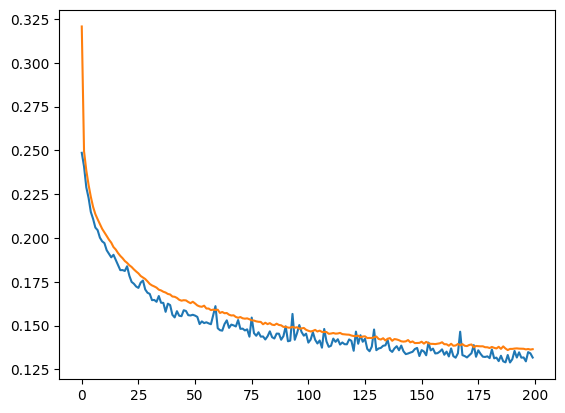

In [317]:
# import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])


In [318]:
y_test_pred = model.predict(X_test_scaled)
y_test_pred_O = np.expm1(y_test_pred)



1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step


In [319]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_O))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_O))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_test_pred_O, squared=False))
print("R-squared Score:", r2_score(y_test, y_test_pred_O))


Mean Absolute Error (MAE): 2.450054959460438
Mean Squared Error (MSE): 92.61377905669151
Root Mean Squared Error (RMSE): 9.623605304494335
R-squared Score: 0.6674035785181174


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_O))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_O))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_test_pred_O, squared=False))
print("R-squared Score:", r2_score(y_test, y_test_pred_O))


Mean Absolute Error (MAE): 2.1947430614580314
Mean Squared Error (MSE): 21.920529268799555
Root Mean Squared Error (RMSE): 4.681936487053147
R-squared Score: 0.8280501995749157


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
X

latitude   longitude    avg_pm10     avg_pm2  county_encoded  \
0       41.153950 -111.937020  111.263967  110.958733               2   
1       40.639800 -111.822510  141.949592  141.612708               1   
2       41.063160 -111.903320   79.045115   78.739573               3   
3       40.574078 -111.958800  141.949592  141.612708               1   
4       41.066500 -111.912445   79.045115   78.739573               3   
...           ...         ...         ...         ...             ...   
265671  40.987300 -111.928600   30.669000   27.952500               3   
265672  40.733440 -111.821510   17.150500   15.120600               1   
265673  40.664246 -111.849230   17.150500   15.120600               1   
265674  40.750816 -111.825290   56.609000   43.520000               1   
265675  41.224422 -111.968376   27.592500   21.269000               2   

        category_encoded  month  
0                      3      9  
1                      4      9  
2                      4      9  
3                      4      9  
4                      4      9  
...                  ...    ...  
265671                 4      1  
265672                 3      1  
265673                 4      1  
265674                 1      1  
265675                 1      1  

[255344 rows x 7 columns]

In [297]:
model.save('../static/data/nnn_model_1_pm_10wind_image.h5')


In [57]:
y_test_pred_O

array([[ 1.7956142],
       [ 3.5925062],
       [28.04021  ],
       ...,
       [ 1.4853419],
       [ 4.168177 ],
       [ 1.0639913]], dtype=float32)

In [52]:
X_test

latitude   longitude    avg_pm10     avg_pm2  county_encoded  \
140082  40.785297 -111.863075   87.882076   87.496826               1   
236733  40.696266 -111.877380   28.262254   27.768127               1   
170538  41.118140 -112.031425   62.482979   57.820677               3   
194180  40.686424 -112.018810   41.071299   40.756886               1   
252070  40.691936 -111.991470  188.458205  185.751415               1   
...           ...         ...         ...         ...             ...   
255933  40.678450 -111.893990   84.995228   78.022272               1   
116423  40.703102 -112.023630   85.823850   85.494863               1   
119824  41.153950 -111.937020    1.399179    1.161071               2   
220288  40.620068 -111.840866  138.224890  137.793809               1   
190267  40.686424 -112.018810   40.624654   40.408681               1   

        category_encoded  month  
140082                 4      3  
236733                 2     10  
170538                 1      2  
194180                 3     12  
252070                 2      1  
...                  ...    ...  
255933                 2      1  
116423                 3      4  
119824                 3      4  
220288                 3     10  
190267                 3     12  

[25671 rows x 7 columns]

In [80]:
# Applying log1p transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

25535

In [131]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, X_test.avg_pm2))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, X_test.avg_pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, X_test.avg_pm2, squared=False))
print("R-squared Score:", r2_score(y_test, X_test.avg_pm2))

Mean Absolute Error (MAE): 53.33974102768495
Mean Squared Error (MSE): 6484.495666902835
Root Mean Squared Error (RMSE): 80.52636628398697
R-squared Score: -60.741582211894645


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [132]:
X_test

latitude   longitude    avg_pm10     avg_pm2  county_encoded  \
72740   40.735943 -111.807720   41.436937   41.041542               1   
261120  41.045660 -111.926216   41.566681   40.656745               3   
181970  40.751663 -111.863530   50.852632   49.713167               1   
126265  40.672577 -111.906160  171.120152  170.413047               1   
197765  40.685400 -111.831660  182.502157  182.271004               1   
...           ...         ...         ...         ...             ...   
206589  40.785297 -111.863075  180.850496  177.990021               1   
119531  40.677616 -111.834690   79.456239   78.847231               1   
107640  41.195732 -111.936554    1.618400    1.441700               2   
102917  40.665700 -111.821106    5.460698    4.971094               1   
14734   41.195310 -111.947450    7.296300    6.664467               2   

        category_encoded  month  
72740                  3      6  
261120                 3      1  
181970                 2     12  
126265                 2      3  
197765                 3     11  
...                  ...    ...  
206589                 4     11  
119531                 4      4  
107640                 3      4  
102917                 4      5  
14734                  4      9  

[25535 rows x 7 columns]

In [ ]:
!

In [150]:
import xgboost as xgb

# Initialize an XGBoost regressor object
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.01,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 100)

# Fit the regressor to the training data
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=40,
            verbose=True)


# Predict
y_pred = xgb_reg.predict(X_test)


[0]	validation_0-rmse:14.07389
[1]	validation_0-rmse:13.99801
[2]	validation_0-rmse:13.92251
[3]	validation_0-rmse:13.84791
[4]	validation_0-rmse:13.77456
[5]	validation_0-rmse:13.75266


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:13.68153
[7]	validation_0-rmse:13.61094
[8]	validation_0-rmse:13.59005
[9]	validation_0-rmse:13.57516
[10]	validation_0-rmse:13.50661
[11]	validation_0-rmse:13.43888
[12]	validation_0-rmse:13.37137
[13]	validation_0-rmse:13.30574
[14]	validation_0-rmse:13.24026
[15]	validation_0-rmse:13.22828
[16]	validation_0-rmse:13.16394
[17]	validation_0-rmse:13.15087
[18]	validation_0-rmse:13.14713
[19]	validation_0-rmse:13.08499
[20]	validation_0-rmse:13.02346
[21]	validation_0-rmse:13.00590
[22]	validation_0-rmse:12.94571
[23]	validation_0-rmse:12.88629
[24]	validation_0-rmse:12.82688
[25]	validation_0-rmse:12.81442
[26]	validation_0-rmse:12.75713
[27]	validation_0-rmse:12.70074
[28]	validation_0-rmse:12.64458
[29]	validation_0-rmse:12.59002
[30]	validation_0-rmse:12.53560
[31]	validation_0-rmse:12.48191
[32]	validation_0-rmse:12.42861
[33]	validation_0-rmse:12.37652
[34]	validation_0-rmse:12.36672
[35]	validation_0-rmse:12.31554
[36]	validation_0-rmse:12.30971
[37]	validat

In [151]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 129.0082508767252
Mean Absolute Error: 4.838014548404276


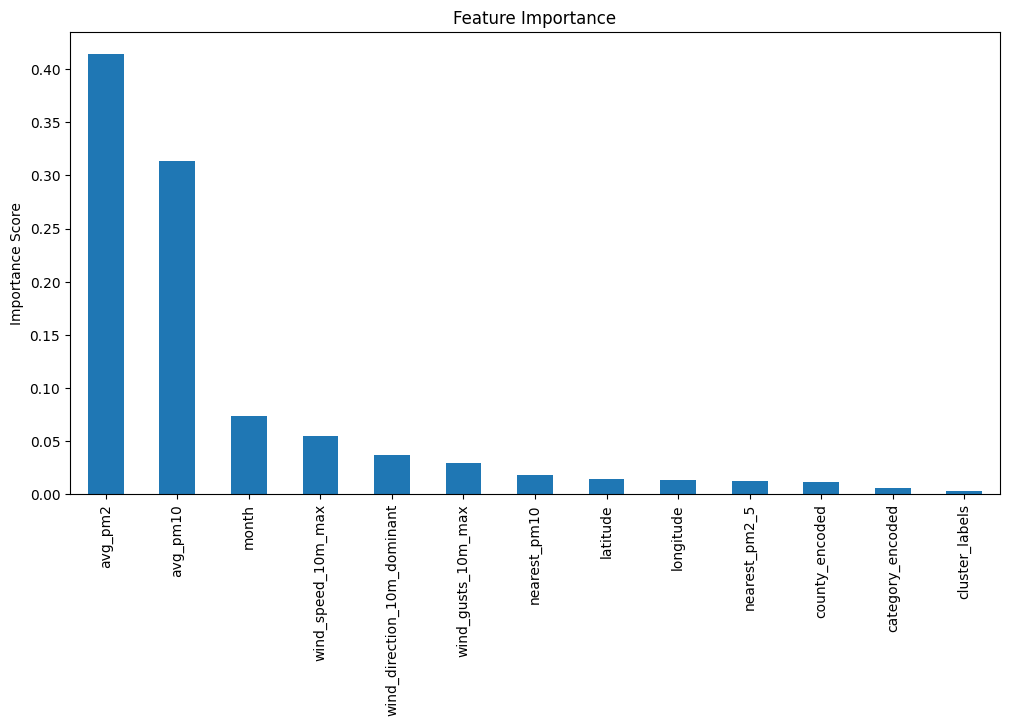

In [152]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = xgb_reg.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=X_train.columns)

# Plotting
features.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importance')
plt.ylabel('Importance Score')
plt.show()


In [188]:
import geopandas as gpd
from shapely.geometry import Point
df = joined_gdf_finalx

In [189]:
df.loc[df.date=='2022-09-09']

Empty DataFrame
Columns: [sensor_id, latitude, longitude, date, county, category, month, pm2, pm10, avg_pm2, avg_pm10]
Index: []

In [190]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Placeholder for results
nearest_pm2_5 = []

for date, group in df.groupby('date'):
    # Extract coordinates and pm2.5 values
    coords = group[['latitude', 'longitude']].values
    pm2_5_values = group['pm2'].values
    
    # NearestNeighbors model, looking for the 2 closest neighbors
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    
    # The nearest sensor (excluding itself) is at index 1 (0 is the sensor itself)
    nearest_indices = indices[:, 1]
    
    # Retrieve the pm2.5 values of the nearest sensors
    nearest_pm2_5_values = pm2_5_values[nearest_indices]
    
    # Append to our placeholder
    nearest_pm2_5.extend(nearest_pm2_5_values)

# Add the nearest sensor's pm2.5 value as a new column in the original DataFrame
df['nearest_pm2_5'] = nearest_pm2_5


In [185]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.date>='2023-01-01']

In [193]:
joined_gdf_finalx = joined_gdf_finalx.loc[joined_gdf_finalx.pm2<=75]

In [194]:
joined_gdf_finalx

sensor_id   latitude   longitude       date        county category  \
1432       108126  41.193970 -111.942700 2023-09-07  Weber County     blue   
1437        13253  41.088875 -111.964510 2023-09-07  Davis County    green   
1438         7466  41.245720 -111.937380 2023-09-07  Weber County    green   
1439         6018  41.124454 -111.924706 2023-09-07  Davis County     blue   
1441        37499  41.057144 -111.949234 2023-09-07  Davis County     blue   
...           ...        ...         ...        ...           ...      ...   
265236      30887  40.942867 -111.890440 2023-01-01  Davis County     blue   
265237      33077  41.137455 -112.029526 2023-01-01  Davis County   orange   
265245      46799  41.087585 -111.978080 2023-01-01  Davis County    green   
265246        443  41.224422 -111.968376 2023-01-01  Weber County      red   
265248      44103  40.896670 -111.856940 2023-01-01  Davis County    green   

        month      pm2     pm10    avg_pm2   avg_pm10  nearest_pm2_5  
1432        9   1.7515   1.9695  17.405900  17.670467         0.9450  
1437        9   1.6170   1.9415  74.684698  75.021625         8.6840  
1438        9   1.4080   1.6135  17.405900  17.670467         3.0460  
1439        9   1.7225   1.8845  74.684698  75.021625         0.5390  
1441        9   1.9045   2.1820  74.684698  75.021625         2.7355  
...       ...      ...      ...        ...        ...            ...  
265236      1   6.5950   8.0045  37.372271  38.302760         4.2445  
265237      1   2.0555   2.2905  37.372271  38.302760         4.7210  
265245      1   3.3930   3.7080  37.372271  38.302760         3.6135  
265246      1   2.9185   3.2925   2.456500   2.792533         9.6760  
265248      1  20.2145  22.2805  37.372271  38.302760        14.3120  

[11825 rows x 12 columns]

In [196]:
df = joined_gdf_finalx

In [197]:
df.nearest_pm2_5
df.pm2

print("Mean Absolute Error (MAE):", mean_absolute_error(df.nearest_pm2_5, df.pm2))
print("Mean Squared Error (MSE):", mean_squared_error(df.nearest_pm2_5, df.pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(df.nearest_pm2_5, df.pm2, squared=False))
print("R-squared Score:", r2_score(df.nearest_pm2_5, df.pm2))

Mean Absolute Error (MAE): 40.55878279069768
Mean Squared Error (MSE): 53085.54693258907
Root Mean Squared Error (RMSE): 230.40300981668852
R-squared Score: -0.022973315710381303


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [198]:
print("Mean Absolute Error (MAE):", mean_absolute_error(df.avg_pm2, df.pm2))
print("Mean Squared Error (MSE):", mean_squared_error(df.avg_pm2, df.pm2))
print("Root Mean Squared Error (RMSE):", mean_squared_error(df.avg_pm2, df.pm2, squared=False))
print("R-squared Score:", r2_score(df.avg_pm2, df.pm2))

Mean Absolute Error (MAE): 39.4314613705801
Mean Squared Error (MSE): 2358.583267522472
Root Mean Squared Error (RMSE): 48.56524752868528
R-squared Score: -2.0573093891876377


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# CNN

In [229]:
import os
from PIL import Image


def resize_image(input_path, output_path, output_size=(128, 128)):
    """Resize an image and save it to the specified output path."""
    with Image.open(input_path) as img:
        # Updated to use Image.LANCZOS for compatibility with newer Pillow versions
        img_resized = img.resize(output_size, Image.LANCZOS)
        img_resized.save(output_path)

def resize_images_in_folder(input_folder, output_folder, output_size=(128, 128)):
    """Resize all images in the input folder and save them to the output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):  # Adjust this if your images have a different format
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            resize_image(input_path, output_path, output_size)
            print(f"Resized and saved {filename} to {output_folder}")
            
input_path = '../static/images/'
output_path = '../static/images_resized2/'
resize_images_in_folder(input_path,output_path)

Resized and saved map_snapshot_736.png to ../static/images_resized2/
Resized and saved map_snapshot_722.png to ../static/images_resized2/
Resized and saved map_snapshot_911.png to ../static/images_resized2/
Resized and saved map_snapshot_905.png to ../static/images_resized2/
Resized and saved map_snapshot_508.png to ../static/images_resized2/
Resized and saved map_snapshot_534.png to ../static/images_resized2/
Resized and saved map_snapshot_252.png to ../static/images_resized2/
Resized and saved map_snapshot_246.png to ../static/images_resized2/
Resized and saved map_snapshot_520.png to ../static/images_resized2/
Resized and saved map_snapshot_291.png to ../static/images_resized2/
Resized and saved map_snapshot_285.png to ../static/images_resized2/
Resized and saved map_snapshot_468.png to ../static/images_resized2/
Resized and saved map_snapshot_440.png to ../static/images_resized2/
Resized and saved map_snapshot_326.png to ../static/images_resized2/
Resized and saved map_snapshot_332

Resized and saved map_snapshot_734.png to ../static/images_resized2/
Resized and saved map_snapshot_720.png to ../static/images_resized2/
Resized and saved map_snapshot_708.png to ../static/images_resized2/
Resized and saved map_snapshot_724.png to ../static/images_resized2/
Resized and saved map_snapshot_730.png to ../static/images_resized2/
Resized and saved map_snapshot_718.png to ../static/images_resized2/
Resized and saved map_snapshot_903.png to ../static/images_resized2/
Resized and saved map_snapshot_240.png to ../static/images_resized2/
Resized and saved map_snapshot_526.png to ../static/images_resized2/
Resized and saved map_snapshot_532.png to ../static/images_resized2/
Resized and saved map_snapshot_254.png to ../static/images_resized2/
Resized and saved map_snapshot_268.png to ../static/images_resized2/
Resized and saved map_snapshot_283.png to ../static/images_resized2/
Resized and saved map_snapshot_297.png to ../static/images_resized2/
Resized and saved map_snapshot_334

Resized and saved map_snapshot_518.png to ../static/images_resized2/
Resized and saved map_snapshot_524.png to ../static/images_resized2/
Resized and saved map_snapshot_242.png to ../static/images_resized2/
Resized and saved map_snapshot_256.png to ../static/images_resized2/
Resized and saved map_snapshot_530.png to ../static/images_resized2/
Resized and saved map_snapshot_901.png to ../static/images_resized2/
Resized and saved map_snapshot_726.png to ../static/images_resized2/
Resized and saved map_snapshot_732.png to ../static/images_resized2/
Resized and saved map_snapshot_769.png to ../static/images_resized2/
Resized and saved map_snapshot_755.png to ../static/images_resized2/
Resized and saved map_snapshot_741.png to ../static/images_resized2/
Resized and saved map_snapshot_796.png to ../static/images_resized2/
Resized and saved map_snapshot_782.png to ../static/images_resized2/
Resized and saved map_snapshot_219.png to ../static/images_resized2/
Resized and saved map_snapshot_231

Resized and saved map_snapshot_541.png to ../static/images_resized2/
Resized and saved map_snapshot_569.png to ../static/images_resized2/
Resized and saved map_snapshot_794.png to ../static/images_resized2/
Resized and saved map_snapshot_780.png to ../static/images_resized2/
Resized and saved map_snapshot_757.png to ../static/images_resized2/
Resized and saved map_snapshot_743.png to ../static/images_resized2/
Resized and saved map_snapshot_747.png to ../static/images_resized2/
Resized and saved map_snapshot_753.png to ../static/images_resized2/
Resized and saved map_snapshot_784.png to ../static/images_resized2/
Resized and saved map_snapshot_790.png to ../static/images_resized2/
Resized and saved map_snapshot_545.png to ../static/images_resized2/
Resized and saved map_snapshot_223.png to ../static/images_resized2/
Resized and saved map_snapshot_237.png to ../static/images_resized2/
Resized and saved map_snapshot_551.png to ../static/images_resized2/
Resized and saved map_snapshot_579

Resized and saved map_snapshot_433.png to ../static/images_resized2/
Resized and saved map_snapshot_427.png to ../static/images_resized2/
Resized and saved map_snapshot_341.png to ../static/images_resized2/
Resized and saved map_snapshot_584.png to ../static/images_resized2/
Resized and saved map_snapshot_590.png to ../static/images_resized2/
Resized and saved map_snapshot_209.png to ../static/images_resized2/
Resized and saved map_snapshot_221.png to ../static/images_resized2/
Resized and saved map_snapshot_547.png to ../static/images_resized2/
Resized and saved map_snapshot_553.png to ../static/images_resized2/
Resized and saved map_snapshot_235.png to ../static/images_resized2/
Resized and saved map_snapshot_786.png to ../static/images_resized2/
Resized and saved map_snapshot_792.png to ../static/images_resized2/
Resized and saved map_snapshot_779.png to ../static/images_resized2/
Resized and saved map_snapshot_745.png to ../static/images_resized2/
Resized and saved map_snapshot_751

Resized and saved map_snapshot_174.png to ../static/images_resized2/
Resized and saved map_snapshot_612.png to ../static/images_resized2/
Resized and saved map_snapshot_606.png to ../static/images_resized2/
Resized and saved map_snapshot_160.png to ../static/images_resized2/
Resized and saved map_snapshot_148.png to ../static/images_resized2/
Resized and saved map_snapshot_809.png to ../static/images_resized2/
Resized and saved map_snapshot_66.png to ../static/images_resized2/
Resized and saved map_snapshot_835.png to ../static/images_resized2/
Resized and saved map_snapshot_821.png to ../static/images_resized2/
Resized and saved map_snapshot_72.png to ../static/images_resized2/
Resized and saved map_snapshot_820.png to ../static/images_resized2/
Resized and saved map_snapshot_73.png to ../static/images_resized2/
Resized and saved map_snapshot_67.png to ../static/images_resized2/
Resized and saved map_snapshot_834.png to ../static/images_resized2/
Resized and saved map_snapshot_808.png

Resized and saved map_snapshot_514.png to ../static/images_resized2/
Resized and saved map_snapshot_272.png to ../static/images_resized2/
Resized and saved map_snapshot_528.png to ../static/images_resized2/
Resized and saved map_snapshot_702.png to ../static/images_resized2/
Resized and saved map_snapshot_716.png to ../static/images_resized2/
Resized and saved map_snapshot_728.png to ../static/images_resized2/
Resized and saved map_snapshot_700.png to ../static/images_resized2/
Resized and saved map_snapshot_714.png to ../static/images_resized2/
Resized and saved map_snapshot_258.png to ../static/images_resized2/
Resized and saved map_snapshot_502.png to ../static/images_resized2/
Resized and saved map_snapshot_264.png to ../static/images_resized2/
Resized and saved map_snapshot_270.png to ../static/images_resized2/
Resized and saved map_snapshot_516.png to ../static/images_resized2/
Resized and saved map_snapshot_338.png to ../static/images_resized2/
Resized and saved map_snapshot_476

Resized and saved map_snapshot_672.png to ../static/images_resized2/
Resized and saved map_snapshot_882.png to ../static/images_resized2/
Resized and saved map_snapshot_128.png to ../static/images_resized2/
Resized and saved map_snapshot_896.png to ../static/images_resized2/
Resized and saved map_snapshot_869.png to ../static/images_resized2/
Resized and saved map_snapshot_841.png to ../static/images_resized2/
Resized and saved map_snapshot_699.png to ../static/images_resized2/
Resized and saved map_snapshot_12.png to ../static/images_resized2/
Resized and saved map_snapshot_855.png to ../static/images_resized2/
Resized and saved map_snapshot_854.png to ../static/images_resized2/
Resized and saved map_snapshot_698.png to ../static/images_resized2/
Resized and saved map_snapshot_840.png to ../static/images_resized2/
Resized and saved map_snapshot_13.png to ../static/images_resized2/
Resized and saved map_snapshot_868.png to ../static/images_resized2/
Resized and saved map_snapshot_129.p

In [120]:
!pip install --upgrade Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [242]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

height = 128
width = 128
channels = 3

# Assuming your images are of shape (height, width, channels)
image_input_shape = (height, width, channels)

image_inputs = Input(shape=image_input_shape)

# Example CNN architecture
y = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_inputs)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = Flatten()(y)
y = Dense(64, activation='relu')(y)


In [251]:
image_inputs



<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_230>

In [249]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence


# Feedforward network for tabular data
input_shape = (X_train_transformed.shape[1],)  # Assuming X_train_transformed is your training feature set
tabular_input = Input(shape=input_shape, name='tabular_input')
x = Dense(256, activation='relu')(tabular_input)
x1 = Dense(128, activation='relu')(x)
x2 = Dense(64, activation='relu')(x1)
tabular_output = Dense(32, activation='relu')(x2)

# CNN for image data
image_input_shape = (128, 128, 3)  # Assuming your images are 224x224 with 3 channels
image_input = Input(shape=image_input_shape, name='image_input')
y = Conv2D(258, kernel_size=(5, 5), activation='relu')(image_input)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(128, (4, 4), activation='relu')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = Flatten()(y)
image_output = Dense(128, activation='relu')(y)

# Combine the outputs of the feedforward and CNN models
combined_features = concatenate([tabular_output, image_output])

# Additional layers after combining
z = Dense(128, activation='relu')(combined_features)
final_output = Dense(1, activation='linear')(z)  # Assuming a regression problem

# Create the combined model
combined_model = Model(inputs=[tabular_input, image_input], outputs=final_output)

# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.01),
                       loss='mean_squared_error')  # Adjust as necessary

combined_model.summary()

# Training the combined model
# Note: X_train_transformed and X_train_images need to be provided as a list of inputs
# Example: combined_model.fit([X_train_transformed, X_train_images], y_train, ...)
# combined_model.compile(optimizer=Adam(learning_rate=0.001),
#                        loss='mean_squared_error')  # Adjust as necessary

from keras.utils import Sequence
import numpy as np

class ImageDataGenerator(Sequence):
    def __init__(self, x_set, y_set, image_ids, batch_size, preprocessed_images):
        self.x = x_set  # Tabular data
        self.y = y_set  # Targets
        self.image_ids = image_ids  # Array of image_ids corresponding to x_set
        self.batch_size = batch_size
        self.preprocessed_images = preprocessed_images  # Dictionary of preprocessed images

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_image_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = np.array([self.preprocessed_images[image_id] for image_id in batch_image_ids])
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Ensure the data is yielded as a tuple of tuples, matching the expected structure
        return ((batch_x, batch_images), batch_y)


# Assuming preprocessed_images is a dictionary where the key is the image_id and the value is the preprocessed image array
# Assuming image_ids is a numpy array of the image_ids in the same order as your training set

batch_size = 64  # Adjust based on your GPU memory
train_generator = ImageDataGenerator(X_train_scaled, y_train_log, np.array(joined_gdf_train['image_id'].values), batch_size, preprocessed_images)

def generator():
    for i in range(len(train_generator)):
        yield train_generator[i]

# Assuming the generator yields batches correctly
# Just create the dataset without the additional batch operation
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, X_train_transformed.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
)

# If the generator yields individual samples, you'd use .batch, but ensure the generator yields the correct shape
# If the generator already handles batching, no need for .batch here

# Now, use the dataset to train your model
history = combined_model.fit(
    dataset,
    epochs=30,
    steps_per_epoch=len(train_generator)  # Make sure this is defined correctly based on your batched data
)







Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 124, 124,  │     19,608 │ image_input[0][0] │
│                     │ 258)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 62, 62,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 258)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 59, 59,    │    528,512 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 256)       │      7,424 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 29, 29,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_149 (Dense)   │ (None, 128)       │     32,896 │ dense_148[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 27, 27,    │     73,792 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 64)        │      8,256 │ dense_149[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 46656)     │          0 │ conv2d_48[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_151 (Dense)   │ (None, 32)        │      2,080 │ dense_150[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 128)       │  5,972,096 │ flatten_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 160)       │          0 │ dense_151[0][0],  │
│ (Concatenate)       │                   │            │ dense_152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 128)       │     20,608 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 1)         │        129 │ dense_153[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,665,401 (25.43 MB)

 Trainable params: 6,665,401 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 11170s 6s/step - loss: 1092962.3750
Epoch 2/30
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - loss: 0.0000e+00
Epoch 3/30


2024-04-09 04:13:25.545522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 13787s 7s/step - loss: 0.7306
Epoch 4/30
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step - loss: 0.0000e+00
Epoch 5/30


2024-04-09 08:03:13.014484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


  10/1980 ━━━━━━━━━━━━━━━━━━━━ 1:28:26 3s/step - loss: 0.7683

KeyboardInterrupt: 

In [206]:
history.history

{'loss': [1.3290486335754395,
  0.0,
  0.34699001908302307,
  0.0,
  0.3381195068359375,
  0.0,
  0.349111407995224,
  0.0,
  0.32573652267456055,
  0.0]}

In [210]:
test_generator = ImageDataGenerator(X_test_transformed, y_test_log, np.array(joined_gdf_test['image_id'].values), batch_size, preprocessed_images)


In [211]:
predictions = []
for i in range(len(test_generator)):
    (batch_x, batch_images), _ = test_generator[i]
    batch_predictions = combined_model.predict([batch_x, batch_images])
    predictions.extend(batch_predictions)

# Convert predictions list to a NumPy array or the desired format
predictions = np.array(predictions).flatten()  # Adjust based on your output layer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

In [212]:

y_test_pred_O = np.expm1(predictions)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_O))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred_O))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_test_pred_O, squared=False))
print("R-squared Score:", r2_score(y_test, y_test_pred_O))


Mean Absolute Error (MAE): 3.283918113551542
Mean Squared Error (MSE): 40.73295097949263
Root Mean Squared Error (RMSE): 6.382237145350572
R-squared Score: 0.6941293804459998


/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [214]:
X_test_transformed.min()

-2.81900882549977

In [219]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_transformed)

In [220]:
# Use the already fitted scaler to transform the test data
X_test_scaled = scaler.transform(X_test_transformed)

# Now X_test_scaled is also scaled between 0 and 1, using the min and max values from the training data


In [223]:
X_test_scaled

array([[0.19212347, 0.58431043, 0.00852511, ..., 0.        , 0.        ,
        0.        ],
       [0.83193549, 0.5394591 , 0.08332544, ..., 0.        , 0.        ,
        0.        ],
       [0.18210534, 0.41736939, 0.0025384 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.24100849, 0.80638334, 0.03958837, ..., 0.        , 0.        ,
        0.        ],
       [0.14177232, 0.98179069, 0.04199769, ..., 0.        , 0.        ,
        0.        ],
       [0.20917249, 0.99936167, 0.23012179, ..., 1.        , 0.        ,
        0.        ]])

In [135]:
gdf = gpd.read_file('../static/data/centroids_data.geojson')
gdf = gdf.reset_index()

In [137]:
gdf.rename(columns = {'index':'image_id'}, inplace = True)

In [230]:
X_train_image = X_train
X_val_image = X_val
X_test_image = X_test

In [231]:
X_train_image=X_train_image[['latitude','longitude']]
X_val_image=X_val_image[['latitude','longitude']]
X_test_image=X_test_image[['latitude','longitude']]

In [232]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming 'latitude' and 'longitude' are the column names in df for lat and long
X_train_image['geometry'] = X_train_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_geo_train = gpd.GeoDataFrame(X_train_image, geometry='geometry')


/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/1671599348.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_image['geometry'] = X_train_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [233]:
# Assuming 'latitude' and 'longitude' are the column names in df for lat and long
X_val_image['geometry'] = X_val_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_geo_val = gpd.GeoDataFrame(X_val_image, geometry='geometry')

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/352020756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_image['geometry'] = X_val_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [234]:
# Assuming 'latitude' and 'longitude' are the column names in df for lat and long
X_test_image['geometry'] = X_test_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
df_geo_test = gpd.GeoDataFrame(X_test_image, geometry='geometry')

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/2478422612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_image['geometry'] = X_test_image.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [235]:
joined_gdf_train = gpd.sjoin_nearest(df_geo_train, gdf, how="left", distance_col="distances")

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/3216149024.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf_train = gpd.sjoin_nearest(df_geo_train, gdf, how="left", distance_col="distances")
/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [236]:
joined_gdf_val = gpd.sjoin_nearest(df_geo_val, gdf, how="left", distance_col="distances")

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/2073384283.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf_val = gpd.sjoin_nearest(df_geo_val, gdf, how="left", distance_col="distances")
/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [237]:
joined_gdf_test = gpd.sjoin_nearest(df_geo_test, gdf, how="left", distance_col="distances")

/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_5629/310390508.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf_test = gpd.sjoin_nearest(df_geo_test, gdf, how="left", distance_col="distances")
/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [166]:
joined_gdf_train[['image_id']]

image_id
148557       419
7241         187
178259       640
92954        203
109592       511
...          ...
119879       620
103694        80
131932       706
146867       828
121958       114

[126697 rows x 1 columns]

In [244]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Load and resize image
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array


In [4]:
unique_image_ids = range(912)  # Assuming image_id goes from 0 to 912
unique_image_paths = ['../static/images_resized/map_snapshot_{}.png'.format(id) for id in unique_image_ids]
#preprocessed_images = {id: load_and_preprocess_image(path) for id, path in zip(unique_image_ids, unique_image_paths)}



In [5]:
unique_image_paths

['../static/images_resized/map_snapshot_0.png',
 '../static/images_resized/map_snapshot_1.png',
 '../static/images_resized/map_snapshot_2.png',
 '../static/images_resized/map_snapshot_3.png',
 '../static/images_resized/map_snapshot_4.png',
 '../static/images_resized/map_snapshot_5.png',
 '../static/images_resized/map_snapshot_6.png',
 '../static/images_resized/map_snapshot_7.png',
 '../static/images_resized/map_snapshot_8.png',
 '../static/images_resized/map_snapshot_9.png',
 '../static/images_resized/map_snapshot_10.png',
 '../static/images_resized/map_snapshot_11.png',
 '../static/images_resized/map_snapshot_12.png',
 '../static/images_resized/map_snapshot_13.png',
 '../static/images_resized/map_snapshot_14.png',
 '../static/images_resized/map_snapshot_15.png',
 '../static/images_resized/map_snapshot_16.png',
 '../static/images_resized/map_snapshot_17.png',
 '../static/images_resized/map_snapshot_18.png',
 '../static/images_resized/map_snapshot_19.png',
 '../static/images_resized/map

In [240]:
def assemble_training_images(joined_gdf, preprocessed_images):
    image_data_list = [preprocessed_images[id] for id in joined_gdf['image_id']]
    return np.array(image_data_list)

X_train_images = assemble_training_images(joined_gdf_train, preprocessed_images)


In [142]:
len(df)

180997

In [148]:
df.head()

sensor_id   latitude   longitude       date            county category  \
0      83563  41.153950 -111.937020 2023-09-09      Weber County    green   
1     122011  40.639800 -111.822510 2023-09-09  Salt Lake County     blue   
2     114467  41.063160 -111.903320 2023-09-09      Davis County     blue   
3      44157  40.574078 -111.958800 2023-09-09  Salt Lake County     blue   
4      30967  41.066500 -111.912445 2023-09-09      Davis County     blue   

   month      pm2     pm10     avg_pm2    avg_pm10  nearest_pm2_5  \
0      9   2.0930   2.3085  110.958733  111.263967        49.3865   
1      9   0.4095   0.5130  141.612708  141.949592        23.8925   
2      9   0.1460   0.2130   78.739573   79.045115        40.2120   
3      9  10.7160  12.9255  141.612708  141.949592        34.2455   
4      9   3.4305   3.9045   78.739573   79.045115        23.8925   

   nearest_pm10  county_encoded  category_encoded  wind_speed_10m_max  \
0       88.2370               2                 3                 8.6   
1       27.4290               1                 4                 8.6   
2       46.0095               3                 4                 8.6   
3       43.4145               1                 4                 8.6   
4       27.4290               3                 4                 8.6   

   wind_gusts_10m_max  wind_direction_10m_dominant  \
0                17.7                        177.0   
1                17.7                        177.0   
2                17.7                        177.0   
3                17.7                        177.0   
4                17.7                        177.0   

                      geometry  
0  POINT (-111.93702 41.15395)  
1   POINT (-111.82251 40.6398)  
2  POINT (-111.90332 41.06316)  
3  POINT (-111.9588 40.574078)  
4  POINT (-111.912445 41.0665)

In [147]:
joined_gdf.head()

sensor_id   latitude   longitude       date       county_left  \
0      83563  41.153950 -111.937020 2023-09-09      Weber County   
1     122011  40.639800 -111.822510 2023-09-09  Salt Lake County   
2     114467  41.063160 -111.903320 2023-09-09      Davis County   
3      44157  40.574078 -111.958800 2023-09-09  Salt Lake County   
4      30967  41.066500 -111.912445 2023-09-09      Davis County   

  category_left  month      pm2     pm10     avg_pm2  ...  image_id  OBJECTID  \
0         green      9   2.0930   2.3085  110.958733  ...       908    200608   
1          blue      9   0.4095   0.5130  141.612708  ...       337    199490   
2          blue      9   0.1460   0.2130   78.739573  ...        82    199142   
3          blue      9  10.7160  12.9255  141.612708  ...       565    199718   
4          blue      9   3.4305   3.9045   78.739573  ...        67    199127   

          GEOID      county_right   Tract  Low  Lowmod  Lowmod_pct  \
0  490572112013      Weber County  211201  365     975      0.4194   
1  490351110012  Salt Lake County  111001  285     370      0.1701   
2  490111261014      Davis County  126101   25      90      0.1091   
3  490351130081  Salt Lake County  113008   20     105      0.0675   
4  490111259062      Davis County  125906  285     445      0.2236   

  category_right  distances  
0          green   0.004905  
1           blue   0.005076  
2           blue   0.017340  
3           blue   0.004678  
4           blue   0.013617  

[5 rows x 30 columns]

# Cluster Images


In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np

# Load the pre-trained model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add global spatial average pooling to summarize features in each feature map
model = Model(inputs=base_model.input, outputs=base_model.output)


In [6]:
def get_image_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    return flattened_features

# Example usage for a list of image paths
image_paths = unique_image_paths
features_list = [get_image_features(img_path, model) for img_path in image_paths]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [92]:
from sklearn.cluster import KMeans

# Convert the list of features into a numpy array
features_array = np.array(features_list)

# Perform K-means clustering
k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=22)
kmeans.fit(features_array)

# Get cluster assignments for each image
cluster_labels = kmeans.labels_



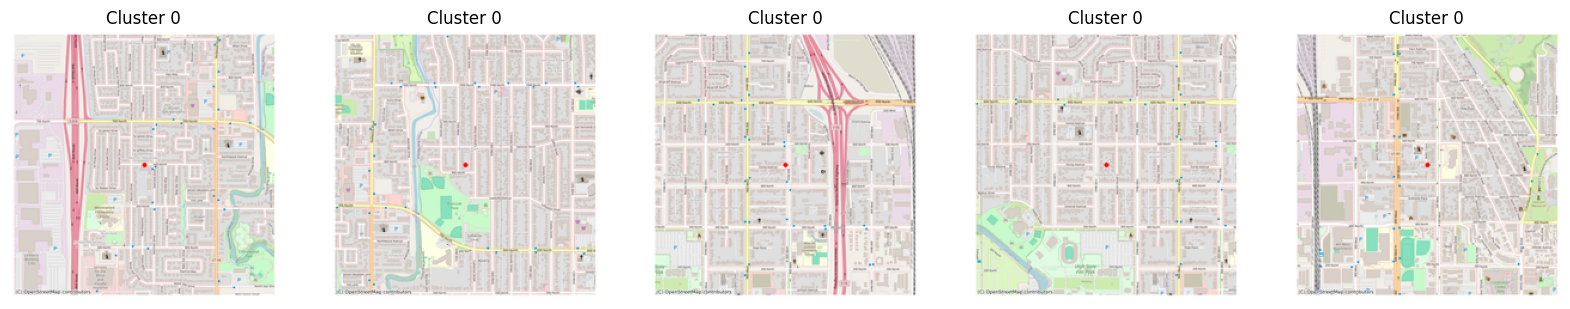

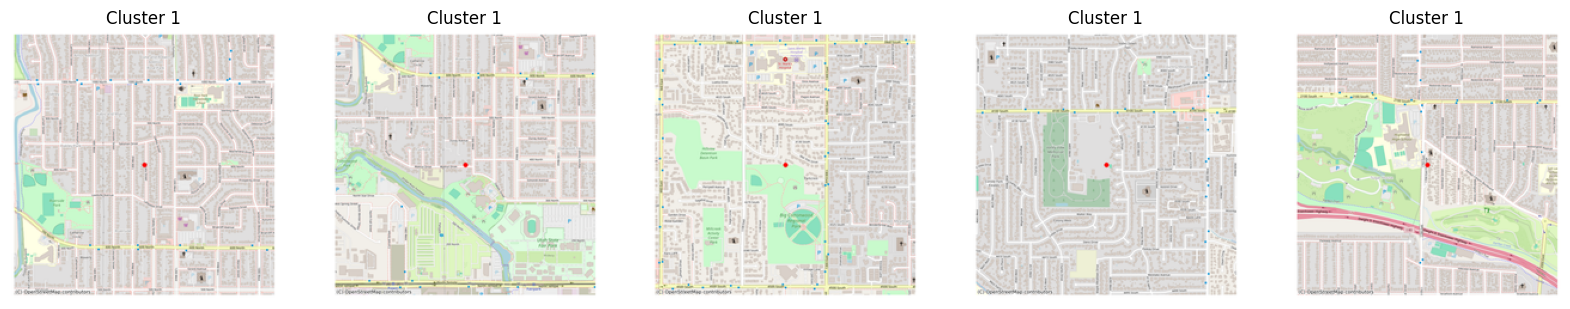

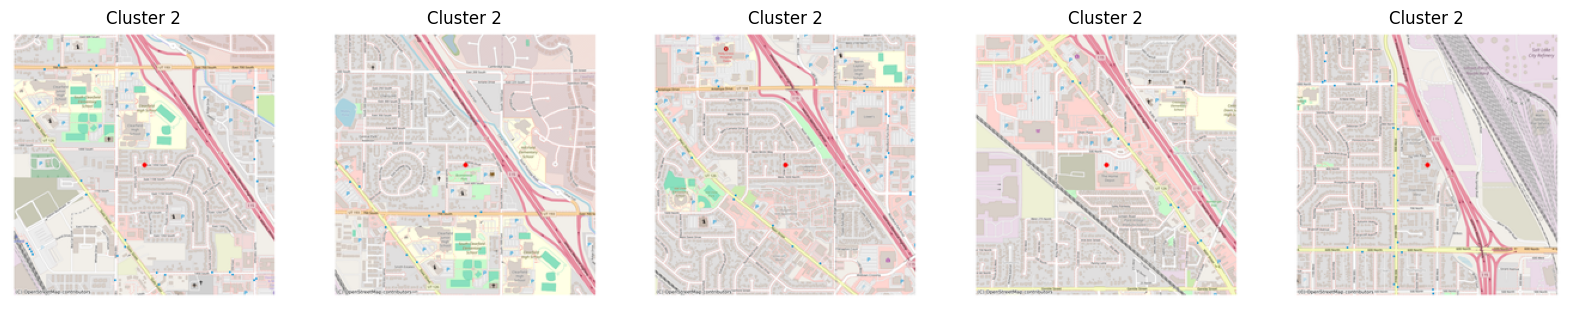

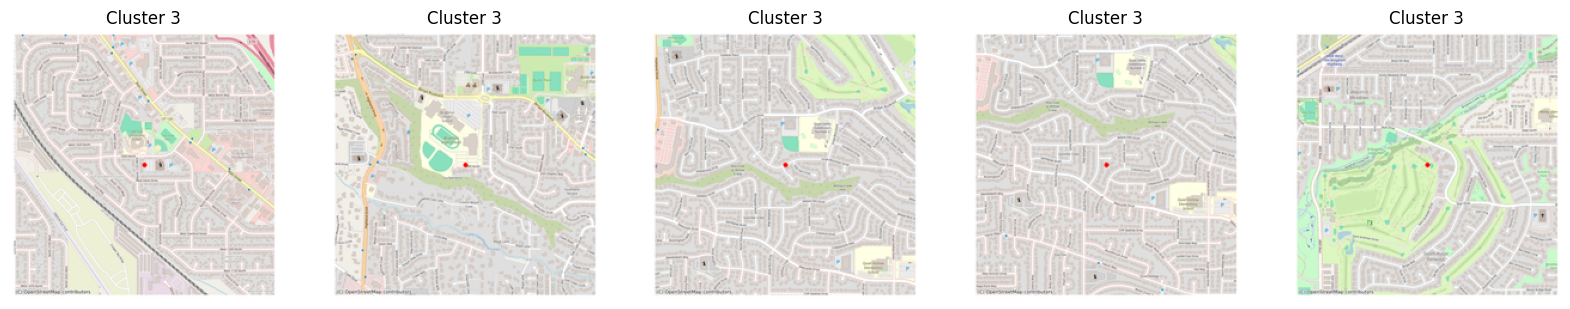

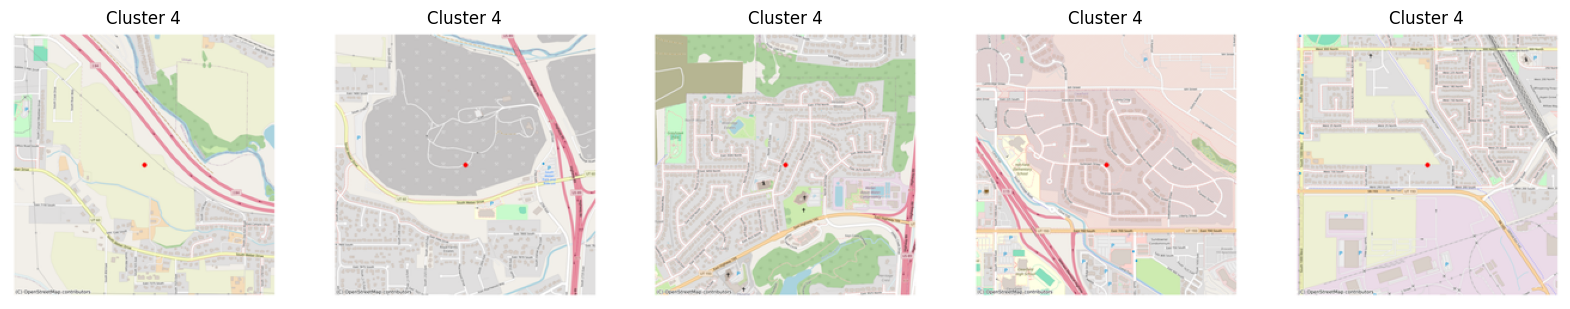

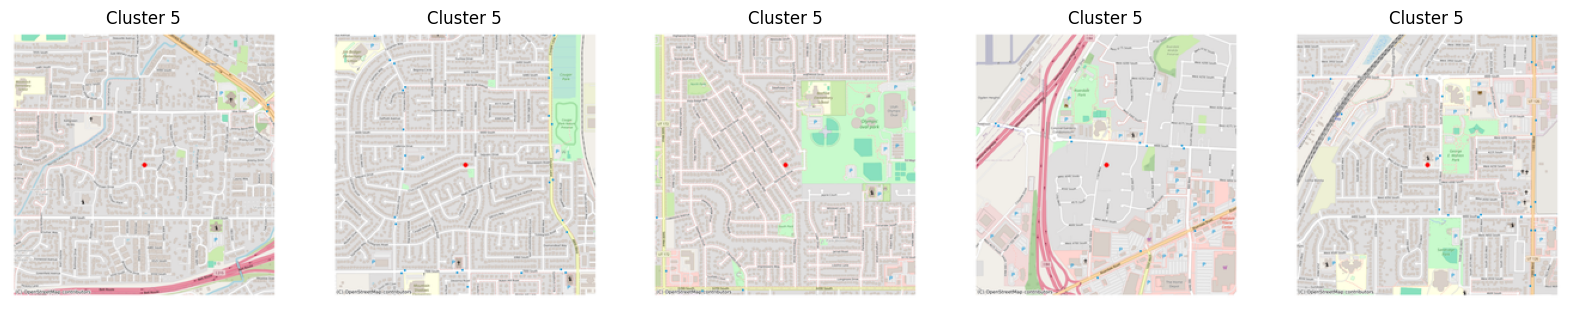

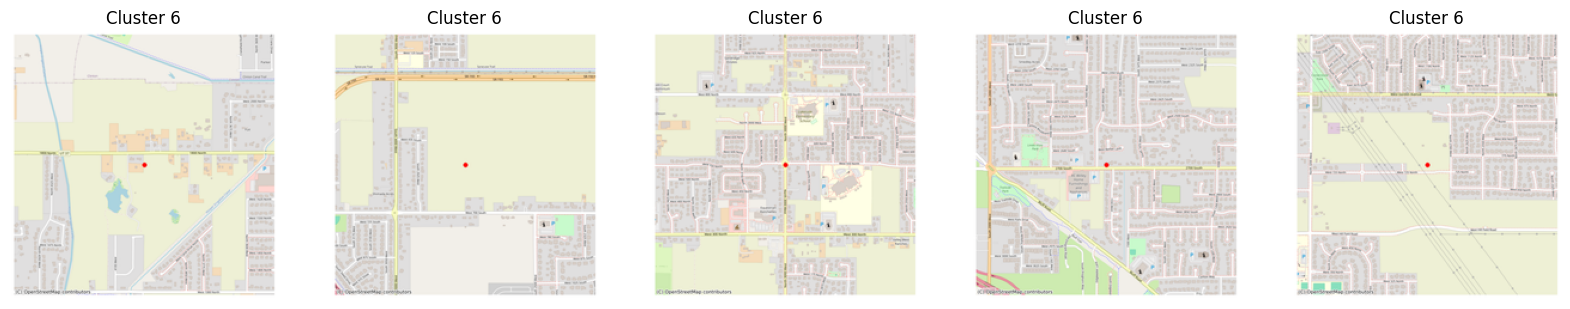

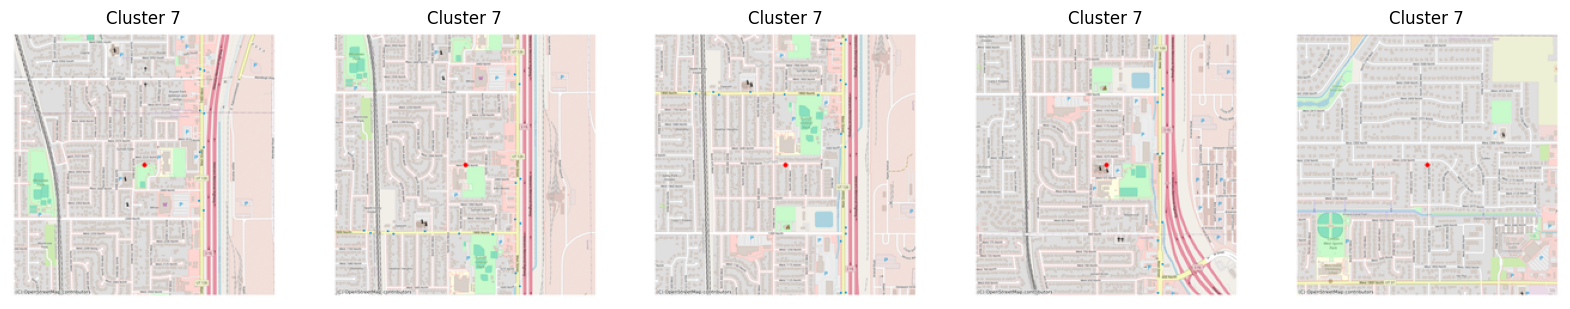

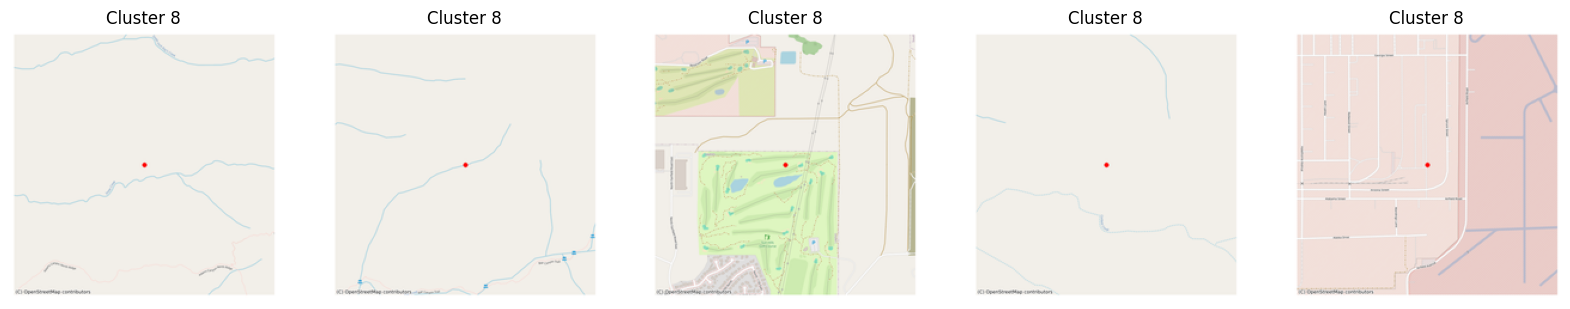

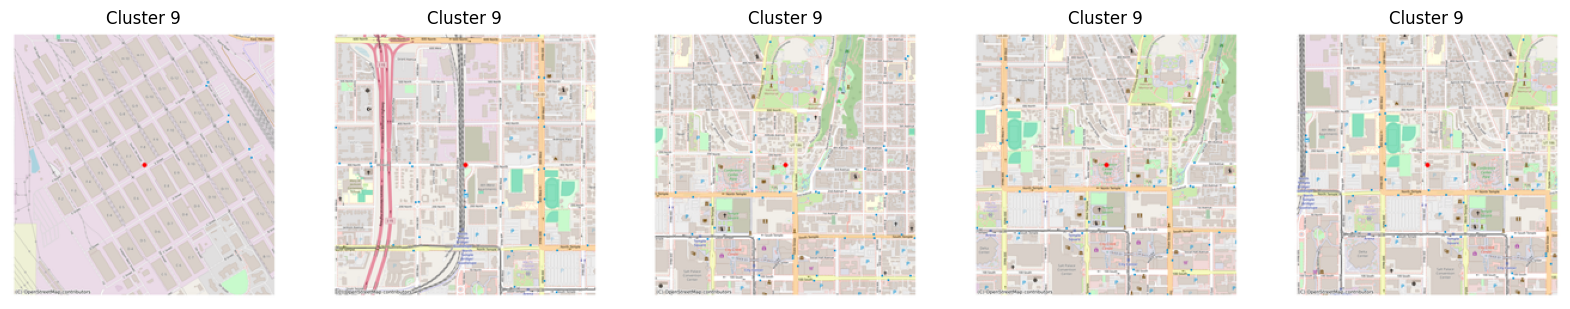

In [93]:
import matplotlib.pyplot as plt

# Display images from each cluster
for i in range(k):
    cluster_indices = np.where(cluster_labels == i)[0]
    plt.figure(figsize=(20, 10))
    for j, index in enumerate(cluster_indices[:5]):  # Display the first 5 images of each cluster
        plt.subplot(1, 5, j + 1)
        img = image.load_img(image_paths[index])
        plt.imshow(img)
        plt.title(f"Cluster {i}")
        plt.axis('off')
    plt.show
    plt.savefig('clusters.png')


In [216]:
cluster_labels

array([8, 8, 4, 8, 4, 8, 4, 4, 8, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7,
       6, 8, 6, 7, 6, 8, 7, 6, 7, 7, 7, 6, 7, 6, 4, 6, 7, 7, 9, 6, 2, 2,
       6, 6, 2, 3, 4, 4, 4, 4, 4, 6, 6, 7, 7, 6, 6, 6, 6, 4, 4, 7, 7, 4,
       4, 4, 4, 4, 4, 7, 4, 2, 4, 6, 4, 6, 6, 6, 4, 4, 4, 4, 4, 8, 4, 4,
       4, 4, 8, 4, 6, 8, 8, 6, 6, 8, 6, 8, 6, 6, 8, 7, 6, 6, 8, 8, 8, 4,
       4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 4, 4, 4, 4,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 4, 4,
       4, 6, 9, 8, 7, 6, 0, 7, 7, 7, 7, 7, 7, 7, 1, 0, 2, 0, 0, 1, 6, 2,
       2, 2, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 8, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 9, 9, 2, 2,
       2, 0, 0, 0, 6, 7, 2, 7, 2, 9, 4, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 2, 7, 7,
       2, 0, 4, 4, 4, 4, 4, 4, 2, 2, 4, 7, 2, 7, 7, 0, 0, 2, 0, 0, 7, 0,
       8, 4, 8, 8, 8, 4, 8, 8, 4, 4, 4, 4, 7, 7, 0,

In [95]:
features_array[0].sum()

28202.904

In [96]:
image_paths

['../static/images_resized/map_snapshot_0.png',
 '../static/images_resized/map_snapshot_1.png',
 '../static/images_resized/map_snapshot_2.png',
 '../static/images_resized/map_snapshot_3.png',
 '../static/images_resized/map_snapshot_4.png',
 '../static/images_resized/map_snapshot_5.png',
 '../static/images_resized/map_snapshot_6.png',
 '../static/images_resized/map_snapshot_7.png',
 '../static/images_resized/map_snapshot_8.png',
 '../static/images_resized/map_snapshot_9.png',
 '../static/images_resized/map_snapshot_10.png',
 '../static/images_resized/map_snapshot_11.png',
 '../static/images_resized/map_snapshot_12.png',
 '../static/images_resized/map_snapshot_13.png',
 '../static/images_resized/map_snapshot_14.png',
 '../static/images_resized/map_snapshot_15.png',
 '../static/images_resized/map_snapshot_16.png',
 '../static/images_resized/map_snapshot_17.png',
 '../static/images_resized/map_snapshot_18.png',
 '../static/images_resized/map_snapshot_19.png',
 '../static/images_resized/map

In [212]:
gdf = gpd.read_file('../static/data/centroids_data.geojson')
gdf

OBJECTID         GEOID        county   Tract  Low Lowmod  Lowmod_pct  \
0      199060  490111251021  Davis County  125102  120    340      0.1833   
1      199061  490111251022  Davis County  125102  245    490      0.1892   
2      199062  490111251031  Davis County  125103  370    850      0.3131   
3      199063  490111251032  Davis County  125103  430   1000      0.4264   
4      199064  490111251041  Davis County  125104  165    475      0.1967   
..        ...           ...           ...     ...  ...    ...         ...   
907    200607  490572112012  Weber County  211201   70    170      0.1560   
908    200608  490572112013  Weber County  211201  365    975      0.4194   
909    200609  490572112021  Weber County  211202  115    270      0.3354   
910    200610  490572112022  Weber County  211202  620   1710      0.3963   
911    200611  490572112023  Weber County  211202  135    360      0.2637   

    category  cluster_labels                     geometry  
0       blue               8  POINT (-111.88081 41.08032)  
1       blue               8  POINT (-111.88004 41.04248)  
2      green               4  POINT (-111.95631 41.13919)  
3      green               8  POINT (-111.94339 41.11548)  
4       blue               4  POINT (-111.91575 41.12877)  
..       ...             ...                          ...  
907     blue               8  POINT (-111.92050 41.15201)  
908    green               4  POINT (-111.93263 41.15613)  
909    green               4  POINT (-111.96410 41.16503)  
910    green               4  POINT (-111.95159 41.15407)  
911    green               4  POINT (-111.93822 41.14257)  

[912 rows x 10 columns]

In [213]:
gdf['cluster_labels'] = cluster_labels

In [214]:
gdf_image_labels = gdf

In [215]:

# Assuming `gdf_image_labels` is your GeoDataFrame
gdf_image_labels.to_file('../static/data/centroids_data.geojson', driver='GeoJSON')
